# Détection de Drift en Maintenance Prédictive

Ce notebook utilise le test de **Kolmogorov-Smirnov (KS)** pour détecter un changement de distribution (drift) dans les capteurs d'une usine.
Le scénario : Un capteur de **température** se dérègle (décalibrage) et nous devons détecter cela automatiquement.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


## Importation des bibliothèques

Nous utilisons :
- `pandas` pour la manipulation des données
- `numpy` pour les calculs numériques
- `matplotlib` pour les visualisations
- `scipy.stats.ks_2samp` pour le test de Kolmogorov-Smirnov à deux échantillons

In [5]:
data_A = pd.read_csv("data/phase_A_historical.csv")
data_B = pd.read_csv("data/phase_B_production.csv")

print("✓ Datasets Maintenance chargés avec succès")
print("Phase A :", data_A.shape)
print("Phase B :", data_B.shape)

# Nouvelles variables (Capteurs)
features = [
    "temperature",
    "vibration",
    "pressure",
    "rpm"
]

✓ Datasets Maintenance chargés avec succès
Phase A : (2000, 5)
Phase B : (2000, 5)


## Chargement des données

Chargement des datasets générés précédemment :
- **Phase A** : données historiques d'entraînement
- **Phase B** : données de production avec drift simulé

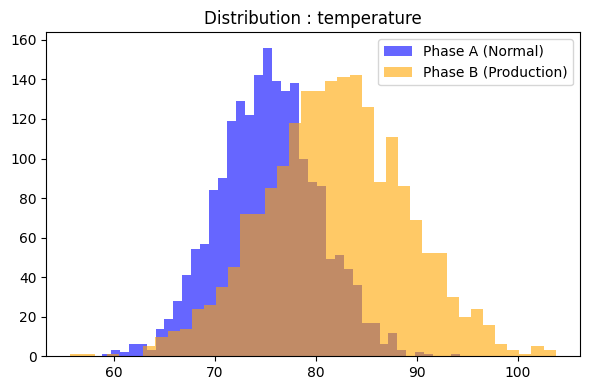

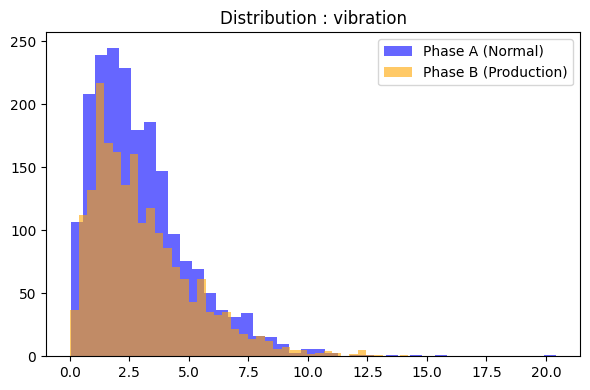

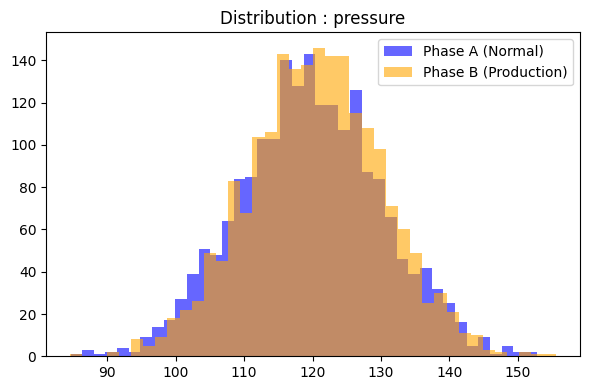

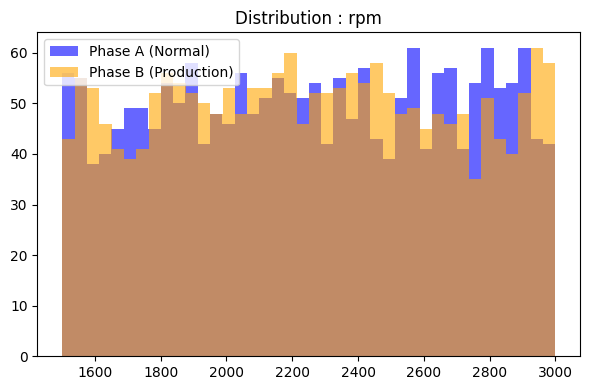

✓ Figures sauvegardées dans le dossier figures/


In [6]:
for feature in features:
    plt.figure(figsize=(6, 4))
    plt.hist(data_A[feature], bins=40, alpha=0.6, label="Phase A (Normal)", color='blue')
    plt.hist(data_B[feature], bins=40, alpha=0.6, label="Phase B (Production)", color='orange')
    plt.title(f"Distribution : {feature}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"images/distribution_{feature}.png", dpi=300, bbox_inches='tight')
    plt.show()

print("✓ Figures sauvegardées dans le dossier figures/")

## Visualisation des distributions

Comparaison visuelle des distributions pour chaque variable entre les deux phases. Cette étape permet d'observer qualitativement les décalages avant l'analyse statistique.

In [7]:
ks_results = []

for feature in features:
    ks_stat, p_value = ks_2samp(
        data_A[feature],
        data_B[feature]
    )
    
    ks_results.append({
        "Variable": feature,
        "KS statistic": ks_stat,
        "p-value": p_value
    })


## Application du test de Kolmogorov-Smirnov

Pour chaque variable, nous calculons :
1. **KS statistic** : distance maximale entre les CDF des deux échantillons
2. **p-value** : probabilité d'observer cette différence si les distributions étaient identiques

Un drift significatif est détecté lorsque la p-value < 0.05 (niveau de confiance de 95%).

In [8]:
ks_df = pd.DataFrame(ks_results)
ks_df


,Variable,KS statistic,p-value
0,temperature,0.4535,1.057928e-185
1,vibration,0.0270,4.596373e-01
2,pressure,0.0435,4.542867e-02
3,rpm,0.0270,4.596373e-01


### Résultats du test KS

Affichage des résultats sous forme de tableau pour analyse.

In [9]:
alpha = 0.05

ks_df["Drift détecté"] = ks_df["p-value"] < alpha
ks_df


,Variable,KS statistic,p-value,Drift détecté
0,temperature,0.4535,1.057928e-185,True
1,vibration,0.0270,4.596373e-01,False
2,pressure,0.0435,4.542867e-02,True
3,rpm,0.0270,4.596373e-01,False


### Interprétation des résultats

Nous appliquons un seuil de significativité α = 0.05 pour déterminer si un drift est présent.

In [10]:
# Résumé visuel des résultats
print("=" * 60)
print("RÉSUMÉ DE LA DÉTECTION DE DRIFT")
print("=" * 60)

for _, row in ks_df.iterrows():
    status = "DRIFT DÉTECTÉ" if row["Drift détecté"] else "Pas de drift"
    print(f"\n{row['Variable']:20} : {status}")
    print(f"  - KS statistic : {row['KS statistic']:.4f}")
    print(f"  - p-value      : {row['p-value']:.6f}")

print("\n" + "=" * 60)
drift_count = ks_df["Drift détecté"].sum()
print(f"Variables avec drift : {drift_count}/{len(ks_df)}")
print("=" * 60)

RÉSUMÉ DE LA DÉTECTION DE DRIFT

temperature          : DRIFT DÉTECTÉ
  - KS statistic : 0.4535
  - p-value      : 0.000000

vibration            : Pas de drift
  - KS statistic : 0.0270
  - p-value      : 0.459637

pressure             : DRIFT DÉTECTÉ
  - KS statistic : 0.0435
  - p-value      : 0.045429

rpm                  : Pas de drift
  - KS statistic : 0.0270
  - p-value      : 0.459637

Variables avec drift : 2/4


## Analyse détaillée des résultats

### Variables avec drift détecté

D'après les résultats du test de Kolmogorov-Smirnov :

1.  **temperature** (Température moteur)
    *   Drift détecté : **OUI**
    *   Explication : Un décalage significatif de la moyenne est observé (simulé comme un déréglage du capteur ou une surchauffe).
    *   **Impact :** Très fort, car c'est une variable clé pour prédire la panne. Le modèle risque de prédire trop de pannes.

2.  **vibration**, **pressure**, **rpm**
    *   Drift détecté : **NON**
    *   Explication : Les distributions sont stables entre la phase A et B.

### Conclusion

Le test KS a correctement identifié que seule la **température** a dérivé. C'est un signal d'alerte pour la maintenance : soit le capteur est faux, soit les machines chauffent vraiment plus que d'habitude.